# Aim: To simulate for 8 assets on IBM qunatum Cloud by increasing the no of alphas , changing different classical optimisers namely COBYLA ,CG POWELL,GradientDescent, and trying to run it on qasm simulator , fake backends i.e. Fake Mumbai, Fake Washington , Fake Torronto

In [1]:
from qiskit.algorithms.optimizers import COBYLA,CG,POWELL, GradientDescent
from qiskit.algorithms import NumPyMinimumEigensolver, VQE,QAOA
from qiskit.opflow import PauliExpectation, CVaRExpectation
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import LinearEqualityToPenalty
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.translators import from_docplex_mp
from qiskit import execute, Aer
from qiskit.utils import algorithm_globals

import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

In [6]:
#maruti,ongc,tatasteel,hindalco,icici
mu5 = np.array([-0.01278393459,-0.01757157357,0.00153724791,-0.015034464,-0.015034464])#maruti,ongc,tatasteel,hindalco,icici

#maruti,ongc,tatasteel,hindalco,icici,britannia,ultra,wipro
mu8 = np.array([-0.01278393459,-0.01757157357,0.00153724791,-0.015034464,-0.015034464,-0.01387133952,-0.01447346195,
                -0.01674339724])

#maruti,ongc,tatasteel,hindalco,icici,britannia,ultra,wipro,apollo,jublfoods
mu10 = np.array([-0.01278393459,-0.01757157357,0.00153724791,-0.015034464,-0.015034464,-0.01387133952,-0.01447346195,
                -0.01674339724,-0.0132387857,-0.01195091376])

sigma5 = np.array(
    [
        [0.0157149876, 0.01543639416,0.01557457106, 0.01548754824, 0.01551981118],
        [0.01543639416,0.01626383626, 0.01518401219, 0.01572622731, 0.01547586679],
        [0.01557457106, 0.01518401219, 0.03221621237,0.01521450154, 0.01560453568],
        [0.01548754824, 0.01572622731,0.01521450154, 0.01609035237, 0.01563323403],
        [0.01551981118, 0.01547586679,0.01560453568, 0.01563323403, 0.0156661810]
        
    ]
)


sigma8 =  np.array(
    [
        [0.0157149876, 0.01543639416,0.01557457106, 0.01548754824, 0.01551981118,0.01552742087,0.01551068247,0.01549833146],
        [0.01543639416,0.01626383626, 0.01518401219, 0.01572622731, 0.01547586679, 0.01523653022,0.01540274745,0.01539792764],
        [0.01557457106, 0.01518401219, 0.03221621237,0.01521450154, 0.01560453568, 0.01568907088,0.01536051938,0.01517390478],
        [0.01548754824, 0.01572622731,0.01521450154, 0.01609035237, 0.01563323403, 0.01546962982,0.01556278296,0.01563908817],
        [0.01551981118, 0.01547586679,0.01560453568, 0.01563323403, 0.01566618101, 0.01551780546,0.01554861694,0.01554772412],
        [0.01552742087,0.01523653022, 0.01568907088, 0.01546962982, 0.01551780546,0.0156690731,0.01550048831,0.01547100286],
        [0.01551068247,0.01540274745,0.01536051938,0.01556278296,0.01554861694,0.01550048831,0.01570878379,0.01551585945],
        [0.01549833146,0.01539792764,0.01517390478,0.01563908817,0.01554772412,0.01547100286,0.01551585945,0.01568793576]
    ]
)

sigma10 = np.array(
    [
        [0.0157149876, 0.01543639416,0.01557457106, 0.01548754824, 0.01551981118,0.01552742087,0.01551068247,0.01549833146,0.01555422578,0.01560541445],
        [0.01543639416,0.01626383626, 0.01518401219, 0.01572622731, 0.01547586679, 0.01523653022,0.01540274745,0.01539792764,0.01529484431,0.01522477939],
        [0.01557457106, 0.01518401219, 0.03221621237,0.01521450154, 0.01560453568, 0.01568907088,0.01536051938,0.01517390478,0.01544208176,0.01533647982],
        [0.01548754824, 0.01572622731,0.01521450154, 0.01609035237, 0.01563323403, 0.01546962982,0.01556278296,0.01563908817,0.01556359729,0.01560570359],
        [0.01551981118, 0.01547586679,0.01560453568, 0.01563323403, 0.01566618101, 0.01551780546,0.01554861694,0.01554772412,0.01554744909,0.01561664097],
        [0.01552742087,0.01523653022, 0.01568907088, 0.01546962982, 0.01551780546, 0.0156690731,0.01550048831,0.01547100286,0.01552910437,0.0155765202],
        [0.01551068247,0.01540274745,0.01536051938,0.01556278296,0.01554861694,0.01550048831,0.01570878379,0.01551585945,0.01551281895,0.01563468601],
        [0.01549833146,0.01539792764,0.01517390478,0.01563908817,0.01554772412,0.01547100286,0.01551585945,0.01568793576,0.0155514752,0.01569287103],
        [0.01555422578,0.01529484431,0.01544208176,0.01556359729,0.01554744909,0.01552910437,0.01551281895,0.0155514752,0.0157783728,0.01565209048],
        [0.01560541445,0.01522477939,0.01533647982,0.01560570359,0.01561664097,0.0155765202,0.01563468601,0.01569287103,0.01565209048,0.0161425637]
    ]
)

In [7]:
# prepare problem instance
n = 8  # number of assets
q = 0.5  # risk factor
budget = n // 2  # budget
penalty = 2 * n  # scaling of penalty term

Creating a quadratic problem

In [9]:
# create docplex model
mdl = Model("portfolio_optimization")
x = mdl.binary_var_list(range(n), name="x")
objective = mdl.sum([mu8[i] * x[i] for i in range(n)])
objective -= q * mdl.sum([sigma10[i, j] * x[i] * x[j] for i in range(n) for j in range(n)])
mdl.maximize(objective)
mdl.add_constraint(mdl.sum(x[i] for i in range(n)) == budget)

# case to
qp = from_docplex_mp(mdl)

Solving the problem classically

In [10]:
%%time
opt_result = MinimumEigenOptimizer(NumPyMinimumEigensolver()).solve(qp)
print(opt_result.prettyprint())

objective function value: -0.17240876954999998
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS
CPU times: user 67.8 ms, sys: 417 µs, total: 68.2 ms
Wall time: 69.3 ms


Using a linear equality to penalty converter on the quadratic problem so that the constraints are taken into account in the objective, making the problem simpler. Converting to an ising model after that

In [11]:
# we convert the problem to an unconstrained problem for further analysis,
# otherwise this would not be necessary as the MinimumEigenSolver would do this
# translation automatically
linear2penalty = LinearEqualityToPenalty(penalty=penalty)
qp = linear2penalty.convert(qp)
_, offset = qp.to_ising()

Using different Classical optimizers

1- Using cobyla optimizer and qasm simulator. We are using CVaR expectation and hence, created a list of alpha values

In [12]:
# set classical optimizer
maxiter = 100
optimizer = COBYLA(maxiter=maxiter)

# set variational ansatz
#ansatz = RealAmplitudes(n, reps=1)
#m = ansatz.num_parameters

# set backend
backend_name = "qasm_simulator"  # use this for QASM simulator
# backend_name = 'aer_simulator_statevector'  # use this for statevector simlator
backend = Aer.get_backend(backend_name)

# run variational optimization for different values of alpha
alphas = [1.0, 0.50, 0.25,0.30,0.40,0.45]  # confidence levels to be evaluated

Fitting CVaR QAOA

In [13]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=backend,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

CPU time

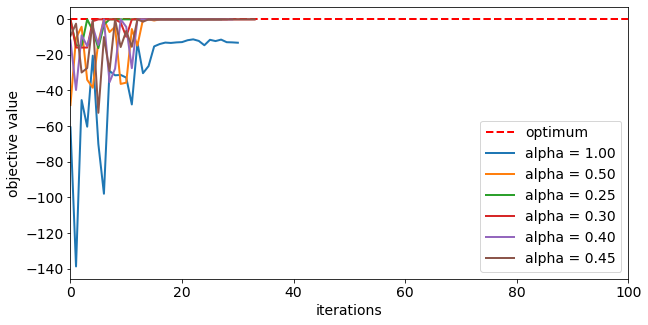

In [14]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [15]:
qaoa.ansatz.count_ops()

OrderedDict([('h', 8), ('PauliEvolution', 2)])

In [16]:
from qiskit import transpile

In [17]:
qc_basis = transpile(qaoa.ansatz, backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

In [18]:
gate_dict

OrderedDict([('cx', 56), ('u', 52)])

Finding the circuit cost

Cost is described as following in the into notebook for a maxcut problem 
task_price = 0.25 # price for submitting task to system (in dollars) 
price_per_CNOT = 0.0001 # price for a single CNOT gate (in dollars) 
price_per_Zrot = 0.00003 # price for a single Z rotation (in dollars) 
price_per_Xrot = 0.00008 # price for a single X rotation (in dollars) 
price_per_shot = p (len(G.edges()) (2 price_per_CNOT + price_per_Zrot) + len(G.nodes()) price_per_Xrot) 
optim_evals = res.nfev # Number of optimization steps i.e. the number of times the quantum hardware was called. 
Meas_shots = shotsin # Number of measurements of quantum hardware i.e. number of times the circuit was applied to the hardware. Cost = (Optim_evals shotsin price_per_shot) + task_price

We decided to define our cost in a similar way below. We calculate the cost for different alpha values seperately as the number of iterations required for convergence is different for different alpha values. The default number of shots is 1024. We just set cost of a single cx gate as 0.0001and the cost of a single qubit gate as 0.00005. Task price is 0.25.

In [19]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 260.55080000000004
Total cost for when alpha is 0.5: 243.7572
Total cost for when alpha is 0.25: 235.36040000000003
Total cost for when alpha is 0.3: 285.74120000000005
Total cost for when alpha is 0.4: 252.15400000000002
Total cost for when alpha is 0.45: 285.74120000000005


We evaluated the cost for different alphas, but we also need to see if we are not too far away from optimal even if the cost is least for any alpha. Based on that, we could conclude which alpha works best. We can see this from the plot itself and also from the cell output where we ran QAOA, but lets print the exact optimal value here.

In [20]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.17240876954997475
The optimal value with alpha 0.5: -0.17240876954997475
The optimal value with alpha 0.25: -0.17240876954997475
The optimal value with alpha 0.3: -0.17240876954997475
The optimal value with alpha 0.4: -0.17240876954997475
The optimal value with alpha 0.45: -0.17240876954997475


alpha=0.25 seems best due to slightly lower cost and the same optimal value as alpha 1 ,alpha 0.5, alpha 0.30,alpha 0.40,alpha 0.45. This is because alpha=0.25 led to convergence much faster.

Circuit depth

In [21]:
qc_basis.depth()

42

Optimizer time

In [22]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 11.619647741317749
Optimizer time for alpha 0.5: 9.788944005966187
Optimizer time for alpha 0.25: 8.672454118728638
Optimizer time for alpha 0.3: 11.539305925369263
Optimizer time for alpha 0.4: 9.997405052185059
Optimizer time for alpha 0.45: 11.313035488128662


2-Using 'CG' optimizer and qasm simulator. We are using CVaR expectation and hence, created a list of alpha values

In [23]:
# set classical optimizer
maxiter = 100
optimizer = CG(maxiter=maxiter)

# set variational ansatz
#ansatz = RealAmplitudes(n, reps=1)
#m = ansatz.num_parameters

# set backend
backend_name = "qasm_simulator"  # use this for QASM simulator
# backend_name = 'aer_simulator_statevector'  # use this for statevector simlator
backend = Aer.get_backend(backend_name)

# run variational optimization for different values of alpha
alphas = [1.0, 0.50, 0.25,0.30,0.40,0.45]  # confidence levels to be evaluated

Fitting CVaR QAOA

In [24]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=backend,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.17321893237004815
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=1.0, x_6=0.0, x_7=0.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

CPU time

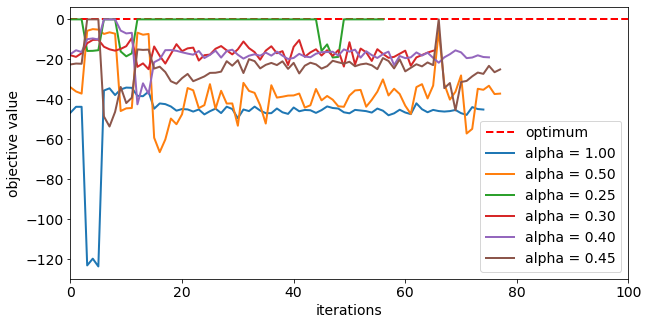

In [25]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [26]:
qaoa.ansatz.count_ops()

OrderedDict([('h', 8), ('PauliEvolution', 2)])

In [27]:
from qiskit import transpile

In [28]:
qc_basis = transpile(qaoa.ansatz, backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

In [29]:
gate_dict

OrderedDict([('cx', 56), ('u', 52)])

Finding the circuit cost

In [30]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 630.0100000000001
Total cost for when alpha is 0.5: 655.2004000000001
Total cost for when alpha is 0.25: 478.86760000000004
Total cost for when alpha is 0.3: 554.4388
Total cost for when alpha is 0.4: 638.4068000000001
Total cost for when alpha is 0.45: 655.2004000000001


We evaluated the cost for different alphas, but we also need to see if we are not too far away from optimal even if the cost is least for any alpha. Based on that, we could conclude which alpha works best. We can see this from the plot itself and also from the cell output where we ran QAOA, but lets print the exact optimal value here.

In [31]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.17240876954997475
The optimal value with alpha 0.5: -0.17240876954997475
The optimal value with alpha 0.25: -0.17240876954997475
The optimal value with alpha 0.3: -0.17240876954997475
The optimal value with alpha 0.4: -0.17321893237004815
The optimal value with alpha 0.45: -0.17240876954997475


alpha=0.25 seems best due to slightly lower cost and the same optimal value as alpha 1,alpha 0.5,alpha 0.3,alpha 0.4,alpha 0.45.This is because alpha=0.25 led to convergence much faster.

Circuit depth

In [32]:
qc_basis.depth()

42

Optimizer time

In [33]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 27.33664608001709
Optimizer time for alpha 0.5: 24.741950511932373
Optimizer time for alpha 0.25: 18.403926372528076
Optimizer time for alpha 0.3: 21.48173713684082
Optimizer time for alpha 0.4: 27.108616590499878
Optimizer time for alpha 0.45: 25.975123405456543


3- Using 'POWELL' optimizer and qasm simulator. We are using CVaR expectation and hence, created a list of alpha values

In [34]:
# set classical optimizer
maxiter = 100
optimizer = POWELL(maxiter=maxiter)

# set variational ansatz
#ansatz = RealAmplitudes(n, reps=1)
#m = ansatz.num_parameters

# set backend
backend_name = "qasm_simulator"  # use this for QASM simulator
# backend_name = 'aer_simulator_statevector'  # use this for statevector simlator
backend = Aer.get_backend(backend_name)

# run variational optimization for different values of alpha
alphas = [1.0, 0.50, 0.25,0.30,0.40,0.45]  # confidence levels to be evaluated

Fitting CVaR QAOA

In [35]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=backend,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

CPU time

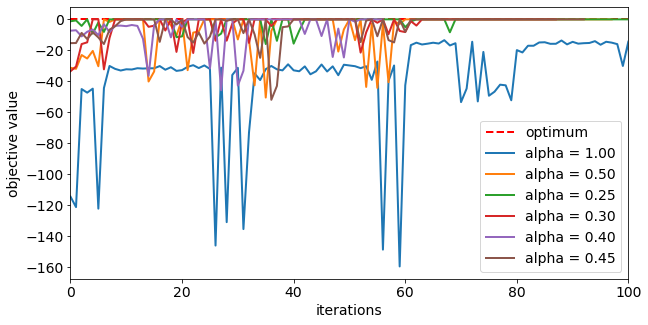

In [36]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [34]:
qaoa.ansatz.count_ops()

OrderedDict([('h', 8), ('PauliEvolution', 2)])

In [35]:
from qiskit import transpile

In [36]:
qc_basis = transpile(qaoa.ansatz, backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

In [37]:
gate_dict

OrderedDict([('cx', 56), ('u', 52)])

Finding the circuit cost

In [37]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 1167.4052000000001
Total cost for when alpha is 0.5: 823.1364000000001
Total cost for when alpha is 0.25: 881.9140000000001
Total cost for when alpha is 0.3: 739.1684
Total cost for when alpha is 0.4: 478.86760000000004
Total cost for when alpha is 0.45: 781.1524000000001


We evaluated the cost for different alphas, but we also need to see if we are not too far away from optimal even if the cost is least for any alpha. Based on that, we could conclude which alpha works best. We can see this from the plot itself and also from the cell output where we ran QAOA, but lets print the exact optimal value here.

In [38]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.17240876954997475
The optimal value with alpha 0.5: -0.17240876954997475
The optimal value with alpha 0.25: -0.17240876954997475
The optimal value with alpha 0.3: -0.17240876954997475
The optimal value with alpha 0.4: -0.17240876954997475
The optimal value with alpha 0.45: -0.17240876954997475


alpha=0.4 seems best due to slightly lower cost and the same optimal value as alpha 0.5,alpha 0.25,alpha 0.3,alpha 1,alpha 0.45.This is because alpha=0.4 led to convergence much faster.

Circuit depth

In [40]:
qc_basis.depth()

42

Optimizer time

In [39]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 49.838890075683594
Optimizer time for alpha 0.5: 33.117530822753906
Optimizer time for alpha 0.25: 35.46926736831665
Optimizer time for alpha 0.3: 29.33750295639038
Optimizer time for alpha 0.4: 19.41197156906128
Optimizer time for alpha 0.45: 33.34273171424866


Using 'GradientDescent' optimizer and qasm simulator. We are using CVaR expectation and hence, created a list of alpha values

In [40]:
# set classical optimizer
maxiter = 100
optimizer = GradientDescent(maxiter=maxiter)

# set variational ansatz
#ansatz = RealAmplitudes(n, reps=1)
#m = ansatz.num_parameters

# set backend
backend_name = "qasm_simulator"  # use this for QASM simulator
# backend_name = 'aer_simulator_statevector'  # use this for statevector simlator
backend = Aer.get_backend(backend_name)

# run variational optimization for different values of alpha
alphas = [1.0, 0.50, 0.25,0.30,0.40,0.45]  # confidence levels to be evaluated

Fitting CVaR QAOA

In [41]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=backend,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

CPU time

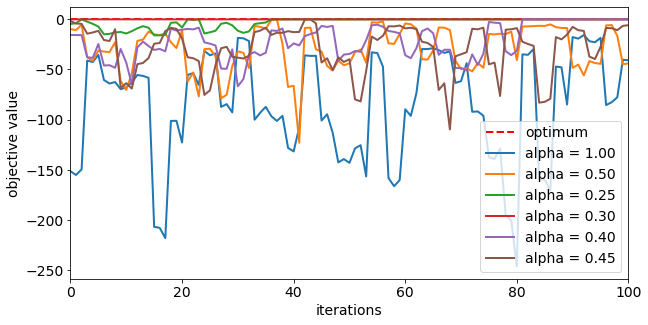

In [42]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [45]:
qaoa.ansatz.count_ops()

OrderedDict([('h', 8), ('PauliEvolution', 2)])

In [46]:
from qiskit import transpile

In [47]:
qc_basis = transpile(qaoa.ansatz, backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

In [48]:
gate_dict

OrderedDict([('cx', 56), ('u', 52)])

Finding the circuit cost

In [43]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 2527.6868000000004
Total cost for when alpha is 0.5: 2527.6868000000004
Total cost for when alpha is 0.25: 2527.6868000000004
Total cost for when alpha is 0.3: 2527.6868000000004
Total cost for when alpha is 0.4: 2527.6868000000004
Total cost for when alpha is 0.45: 2527.6868000000004


In [44]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.17240876954997475
The optimal value with alpha 0.5: -0.17240876954997475
The optimal value with alpha 0.25: -0.17240876954997475
The optimal value with alpha 0.3: -0.17240876954997475
The optimal value with alpha 0.4: -0.17240876954997475
The optimal value with alpha 0.45: -0.17240876954997475


Here we can see cost and optimal values of all the alphas are same.

Circuit depth

In [51]:
qc_basis.depth()

42

Optimizer time

In [45]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 103.1867105960846
Optimizer time for alpha 0.5: 100.47726821899414
Optimizer time for alpha 0.25: 101.04776048660278
Optimizer time for alpha 0.3: 84.55284667015076
Optimizer time for alpha 0.4: 93.10672092437744
Optimizer time for alpha 0.45: 147.24816393852234


Trying different fake backends and using noise models for the same experiment

The fake backends are built to mimic the behaviors of IBM Quantum systems using system snapshots. The system snapshots contain important information about the quantum system such as coupling map, basis gates, qubit properties (T1, T2, error rate, etc.) which are useful for testing the transpiler and performing noisy simulation of the system.

In [1]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeSydney, FakeMumbai
from qiskit.utils import QuantumInstance

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
device_backend = FakeMumbai()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'cx', 'id', 'sx', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [46]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

CPU time

Note: With the above noise model, results seem slightly different from what we got with the qasm simulator

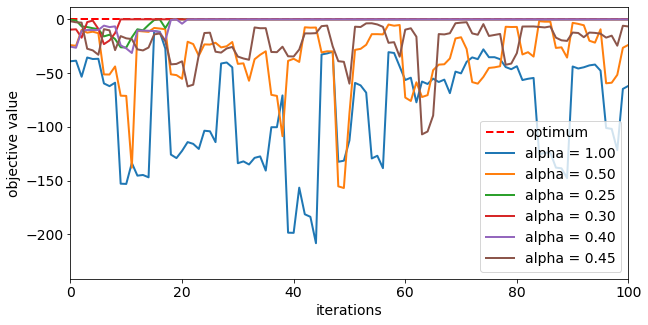

In [47]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [48]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 113), ('u', 64)])

In [49]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 4469.4980000000005
Total cost for when alpha is 0.5: 4469.4980000000005
Total cost for when alpha is 0.25: 4469.4980000000005
Total cost for when alpha is 0.3: 4469.4980000000005
Total cost for when alpha is 0.4: 4469.4980000000005
Total cost for when alpha is 0.45: 4469.4980000000005


In [50]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))
    

The optimal value with alpha 1.0: -0.17240876954997475
The optimal value with alpha 0.5: -0.17240876954997475
The optimal value with alpha 0.25: -0.17240876954997475
The optimal value with alpha 0.3: -0.17240876954997475
The optimal value with alpha 0.4: -0.17240876954997475
The optimal value with alpha 0.45: -0.17240876954997475


In [51]:
### Circuit depth ###

qc_basis.depth()

92

In [52]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 270.50078868865967
Optimizer time for alpha 0.5: 197.46110939979553
Optimizer time for alpha 0.25: 203.55997371673584
Optimizer time for alpha 0.3: 198.56497144699097
Optimizer time for alpha 0.4: 314.4909110069275
Optimizer time for alpha 0.45: 385.9013617038727


2-FakeWashington device backend

In [53]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeWashington
from qiskit.utils import QuantumInstance

device_backend = FakeWashington()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (260581.28986315246 > 2 * 80026.57875131005). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (115349.1827351713 > 2 * 56743.169831786116). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (260581.28986315246 > 2 * 80026.57875131005). Truncating to maximum value.
  warn("De

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'cx', 'id', 'sx', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 

/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (0.00026058128986315243 > 2 * 8.002657875131006e-05). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (0.0001153491827351713 > 2 * 5.674316983178612e-05). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"


In [54]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.1729605453299996
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=1.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

CPU times

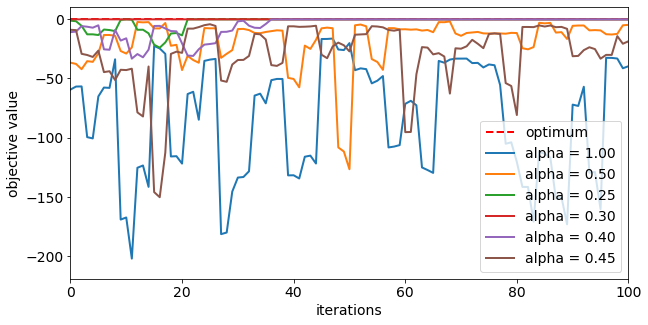

In [55]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [56]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 119), ('u', 70)])

In [57]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 4746.8996
Total cost for when alpha is 0.5: 4746.8996
Total cost for when alpha is 0.25: 4746.8996
Total cost for when alpha is 0.3: 4746.8996
Total cost for when alpha is 0.4: 4746.8996
Total cost for when alpha is 0.45: 4746.8996


In [58]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.17240876954997475
The optimal value with alpha 0.5: -0.1729605453299996
The optimal value with alpha 0.25: -0.17240876954997475
The optimal value with alpha 0.3: -0.17240876954997475
The optimal value with alpha 0.4: -0.17240876954997475
The optimal value with alpha 0.45: -0.17240876954997475


In [59]:
### Circuit depth ###

qc_basis.depth()

93

In [60]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 540.6254053115845
Optimizer time for alpha 0.5: 563.5416314601898
Optimizer time for alpha 0.25: 552.7638094425201
Optimizer time for alpha 0.3: 542.6874556541443
Optimizer time for alpha 0.4: 547.1445426940918
Optimizer time for alpha 0.45: 539.5209469795227


3-FakeToronto device backend

In [61]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeToronto
from qiskit.utils import QuantumInstance

device_backend = FakeToronto()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'cx', 'id', 'sx', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [62]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.17476137423005866
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=0.0, x_6=1.0, x_7=1.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

CPU time

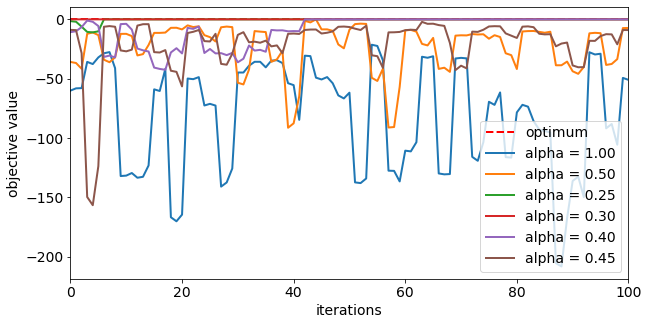

In [63]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [64]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 107), ('u', 100)])

In [65]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 4839.366800000001
Total cost for when alpha is 0.5: 4839.366800000001
Total cost for when alpha is 0.25: 4839.366800000001
Total cost for when alpha is 0.3: 4839.366800000001
Total cost for when alpha is 0.4: 4839.366800000001
Total cost for when alpha is 0.45: 4839.366800000001


In [66]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.17240876954997475
The optimal value with alpha 0.5: -0.17476137423005866
The optimal value with alpha 0.25: -0.17240876954997475
The optimal value with alpha 0.3: -0.17240876954997475
The optimal value with alpha 0.4: -0.17240876954997475
The optimal value with alpha 0.45: -0.17240876954997475


Note : Results with different fake backends shows identical cost and optimal value for each Alpha

### Conclusion : 1) Fake Backend Washington was a poor choice where it has large no of Qubits i.e.127 which is not require for our used cases.
### 2) For a particular case of Optimisers it is showing different alpha's cost when trying on simulator and on fake backends

 